In [3]:
#loading libraries
suppressMessages(library(DESeq2))
suppressMessages(library(edgeR))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(gsheet))
suppressMessages(library(data.table))
suppressMessages(library(vegan))
suppressMessages(library(EnvStats))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))

Warning message:
“package ‘gsheet’ was built under R version 4.2.2”
Warning message:
“package ‘vegan’ was built under R version 4.2.2”
Warning message:
“package ‘permute’ was built under R version 4.1.3”
Warning message:
“package ‘EnvStats’ was built under R version 4.2.2”


In [4]:
rm(list=ls())
sample_key = fread("/workdir/omm35/paper_urine_cfrna/metadata/gvhd_plasma_urine_key.tsv")

In [5]:
set.seed(119)
#Urine samples
gvhd_tissuesUrine = fread("/local/workdir/omm35/test_cfrna_deconvolution/output/gvhd_urine_updated_ref_BP.protein_coding.tsv", header=TRUE)
gvhd_tissuesUrine$sample_id=gsub("\\.",'-',gvhd_tissuesUrine$sample_id)
#dim(gvhd_tissuesUrine)
#########
#########
samples_after_QC = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")
samples_after_QC = samples_after_QC %>% filter(biofluid=="gvhd_urine") %>% select(sample_id,biofluid)
###Merging the dataframe
###Merging the dataframe
gvhd_tissuesUrine = samples_after_QC %>% left_join(gvhd_tissuesUrine, by="sample_id")
##############
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")
sample_key = sample_key[,2:ncol(sample_key)]
sample_key = sample_key %>% filter(use_pair==TRUE)  %>% select(SubjectID,event_sym,sample_id_urine)
colnames(sample_key)[3]="sample_id" 
#######
gvhd_tissuesUrine = gvhd_tissuesUrine  %>% left_join(sample_key, by="sample_id")

####
gvhd_tissuesUrine$event_sym = factor( gvhd_tissuesUrine$event_sym, levels=c("PR","D0","E","1M", "2M","3M","6M","R2","D1","D2"))
############
#####taking grouped means of columns
gvhd_tissuesUrine_means = gvhd_tissuesUrine %>% select(-biofluid,-SubjectID,-sample_id)  %>% 
group_by(event_sym) %>% summarize ( n = n(), 
                              single_row = ifelse(n == 1, TRUE, FALSE),
                              across(.cols = everything(), .fns = mean))  %>% select(-n,-single_row)

###making a long df and subsetting 
gvhd_tissuesUrine_means = melt(gvhd_tissuesUrine_means, id.vars = c('event_sym'))
colnames(gvhd_tissuesUrine_means)=c("event_sym","cell_type","fraction")
#gvhd_tissuesUrine_means = gvhd_tissuesUrine_means %>% group_by(event_sym) %>% arrange(desc(fraction)) %>% slice(1:5)
###
top_5_cell_types = gvhd_tissuesUrine_means %>% group_by(cell_type) %>% summarize(mean=mean(fraction))  %>% arrange(desc(mean)) %>% slice(1:10)
gvhd_tissuesUrine_means = gvhd_tissuesUrine_means %>% filter(cell_type  %in% top_5_cell_types$cell_type)

#########################
gvhd_tissuesUrine_means  = gvhd_tissuesUrine_means   %>% group_by(event_sym) %>% 
mutate(event_sym = event_sym, cell_type="other", fraction = 1-sum(fraction)) %>% 
distinct()%>% bind_rows(gvhd_tissuesUrine_means , .) %>% arrange(event_sym) 
#########################
gvhd_tissuesUrine_means  = gvhd_tissuesUrine_means  %>% ungroup() %>% complete(event_sym, cell_type, fill = list(fraction = 0))

########################
gvhd_tissuesUrine_means$event_sym = factor( gvhd_tissuesUrine_means$event_sym, levels=c("PR","D0","E","1M", "2M","3M","6M"))
myLevels <- gvhd_tissuesUrine_means %>% arrange(desc(fraction))
gvhd_tissuesUrine_means$cell_type <- factor(gvhd_tissuesUrine_means$cell_type , levels=unique(myLevels$cell_type) )
#######################
my_palette <-c('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB',"#E54C44","#6DED88","#732D9F","#01A03F","#FF85EE","#287500","#705CD2","#EFD245","#0F80F8",
"#E2A423","#310D67","#AFE382","#6E006A","#01A665","#D944A6","#6C8400","#A493FF","#E98429","#0175CE","#FDCD69",
"#002965","#A9E395","#F14793","#006630","#FF8BC0","#525F00","#7EACFF","#B0320A","#004589","#FD7547","#3B1B55","#FFAF73","#AB7EC0","#A05500","#E1B6FF","#654700","#A60030","#FF7D6D","#6C0200","#800030")
########################
gvhd_tissuesUrine_means = gvhd_tissuesUrine_means %>% mutate(event_num= ifelse(event_sym=="PR",1,
                                                                               ifelse(event_sym=="D0",2,
                                                                               ifelse(event_sym=="E",3,
                                                                               ifelse(event_sym=="1M",4,
                                                                                ifelse(event_sym=="2M",5,
                                                                                ifelse(event_sym=="3M",6,
                                                                                ifelse(event_sym=="6M",7,NA)))) ))
))
gvhd_tissuesUrine_means = gvhd_tissuesUrine_means[!is.na(gvhd_tissuesUrine_means$event_num),]
gvhd_tissuesUrine_means$biofluid="Urine"

options(repr.plot.width=20, repr.plot.height=10)
p2=ggplot(gvhd_tissuesUrine_means) +  
geom_area( aes(x=(event_sym), y=fraction, fill=cell_type),alpha=1 , size=0.3, colour="black",stat = 'identity') + 
geom_area( aes(x=as.numeric(event_sym), y=fraction, fill=cell_type),alpha=1 , size=0.3, colour="black",stat = 'identity')+
scale_fill_manual(values=my_palette)+ theme_classic()+facet_wrap(~biofluid)+
xlab("Event")+ theme(
axis.text.x = element_text(size=6, color="black"), 
axis.text.y = element_text(size=6,color="black"),
legend.text = element_text(size=6,color="black")
) 


Warning message in melt(gvhd_tissuesUrine_means, id.vars = c("event_sym")):
“The melt generic in data.table has been passed a tbl_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(gvhd_tissuesUrine_means). In the next version, this warning will become an error.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


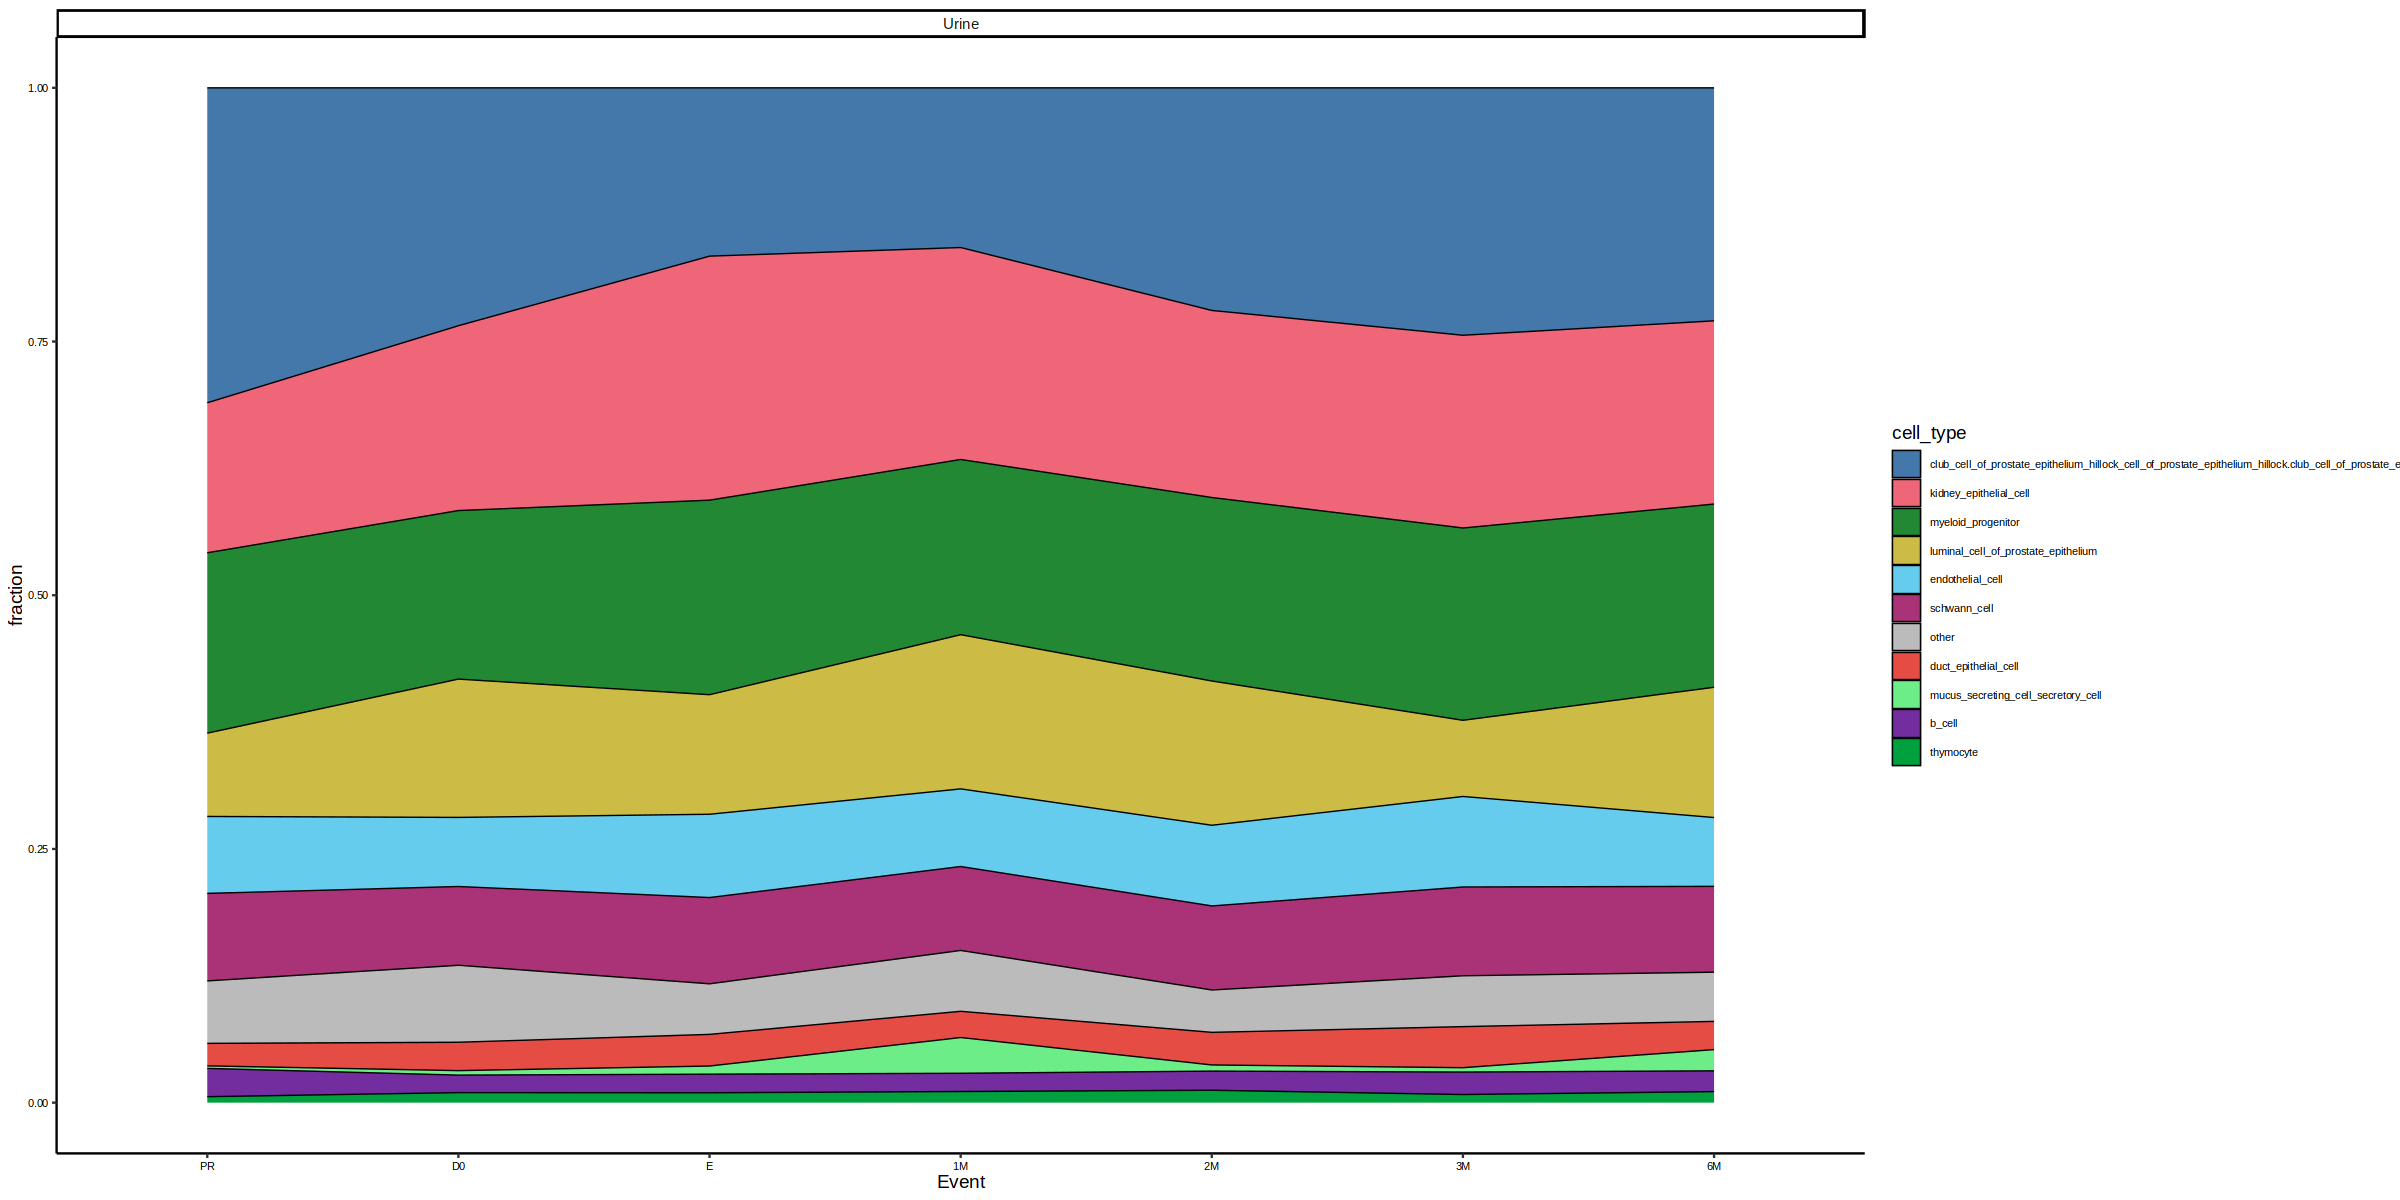

In [6]:
p2

In [1]:
seed=119
set.seed(seed)
####plasma samples
gvhd_tissuesPlasma = fread("/local/workdir/omm35/test_cfrna_deconvolution/output/gvhd_plasma_updated_ref_BP.protein_coding.tsv", header=TRUE)
dim(gvhd_tissuesPlasma)
#######
samples_after_QC = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")
samples_after_QC = samples_after_QC %>% filter(biofluid=="gvhd_plasma")%>% select(sample_id,biofluid)


###Merging the dataframe
gvhd_tissuesPlasma = samples_after_QC %>% left_join(gvhd_tissuesPlasma, by="sample_id")
#####loading sample key -created by Connor
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")
sample_key = sample_key[,2:ncol(sample_key)]
sample_key = sample_key %>% filter(use_pair==TRUE) %>% select(SubjectID,event_sym,sample_id_plasma)
colnames(sample_key)[3]="sample_id" 
gvhd_tissuesPlasma = gvhd_tissuesPlasma %>% left_join(sample_key, by="sample_id")
#################
gvhd_tissuesPlasma$event_sym = factor(gvhd_tissuesPlasma$event_sym, levels=c("PR","D0","E","1M", "2M","3M","6M","R2","D1","D2"))



#####taking grouped means of columns
gvhd_tissuesPlasma_means = gvhd_tissuesPlasma %>% select(-biofluid,-SubjectID,-sample_id)  %>% 
group_by(event_sym) %>% summarize ( n = n(), 
                              single_row = ifelse(n == 1, TRUE, FALSE),
                              across(.cols = everything(), .fns = mean))  %>% select(-n,-single_row)

###making a long df and subsetting 

gvhd_tissuesPlasma_means = melt(gvhd_tissuesPlasma_means, id.vars = c('event_sym'))
colnames(gvhd_tissuesPlasma_means)=c("event_sym","cell_type","fraction")
#########################
top_5_cell_types = gvhd_tissuesPlasma_means %>% group_by(cell_type) %>% summarize(mean=mean(fraction))  %>% arrange(desc(mean)) %>% slice(1:10)

gvhd_tissuesPlasma_means = gvhd_tissuesPlasma_means %>% filter(cell_type  %in% top_5_cell_types$cell_type)

gvhd_tissuesPlasma_means  = gvhd_tissuesPlasma_means   %>% group_by(event_sym) %>% 
mutate(event_sym = event_sym, cell_type="other", fraction = 1-sum(fraction)) %>% 
distinct()%>% bind_rows(gvhd_tissuesPlasma_means , .) %>% arrange(event_sym) 
# #colnames(ktx_tissuesUrine)
gvhd_tissuesPlasma_means  = gvhd_tissuesPlasma_means  %>% ungroup() %>% complete(event_sym, cell_type, fill = list(fraction = 0))
######




gvhd_tissuesPlasma_means$event_sym = factor(gvhd_tissuesPlasma_means$event_sym, levels=c("PR","D0","E","1M", "2M","3M","6M","R2","D1","D2"))

myLevels <- gvhd_tissuesPlasma_means %>% arrange(desc(fraction))


gvhd_tissuesPlasma_means$cell_type <- factor(gvhd_tissuesPlasma_means$cell_type , levels=unique(myLevels$cell_type) )
#####################################
#######
my_palette <-c('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB',"#E54C44","#6DED88","#732D9F","#01A03F","#FF85EE","#287500","#705CD2","#EFD245","#0F80F8",
"#E2A423","#310D67","#AFE382","#6E006A","#01A665","#D944A6","#6C8400","#A493FF","#E98429","#0175CE","#FDCD69",
"#002965","#A9E395","#F14793","#006630","#FF8BC0","#525F00","#7EACFF","#B0320A","#004589","#FD7547","#3B1B55","#FFAF73","#AB7EC0","#A05500","#E1B6FF","#654700","#A60030","#FF7D6D","#6C0200","#800030")


gvhd_tissuesPlasma_means = gvhd_tissuesPlasma_means %>% mutate(event_num= ifelse(event_sym=="PR",1,
                                                                               ifelse(event_sym=="D0",2,
                                                                               ifelse(event_sym=="E",3,
                                                                               ifelse(event_sym=="1M",4,
                                                                                ifelse(event_sym=="2M",5,
                                                                                ifelse(event_sym=="3M",6,
                                                                                ifelse(event_sym=="6M",7,NA)))) ))
))

gvhd_tissuesPlasma_means = gvhd_tissuesPlasma_means[!is.na(gvhd_tissuesPlasma_means$event_num),]


gvhd_tissuesPlasma_means$biofluid="Plasma"
library(repr)
options(repr.plot.width=20, repr.plot.height=10)
p3<-ggplot(gvhd_tissuesPlasma_means) +  
geom_area(aes(x=event_sym, y=fraction, fill=cell_type),alpha=1 , size=0.3, colour="black",stat = 'identity') + 
geom_area(aes(x=as.numeric(event_sym), y=fraction, fill=cell_type),alpha=1 , size=0.3, colour="black",stat = 'identity')+
scale_fill_manual(values=my_palette)+ theme_classic()+ facet_wrap(~biofluid)+
scale_x_discrete(breaks = c("PR","D0","E","1M", "2M","3M","6M")) +
xlab("Event")+ theme(
axis.text.x = element_text(size=6, color="black"), 
axis.text.y = element_text(size=6,color="black"),
legend.text = element_text(size=6,color="black")
)



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


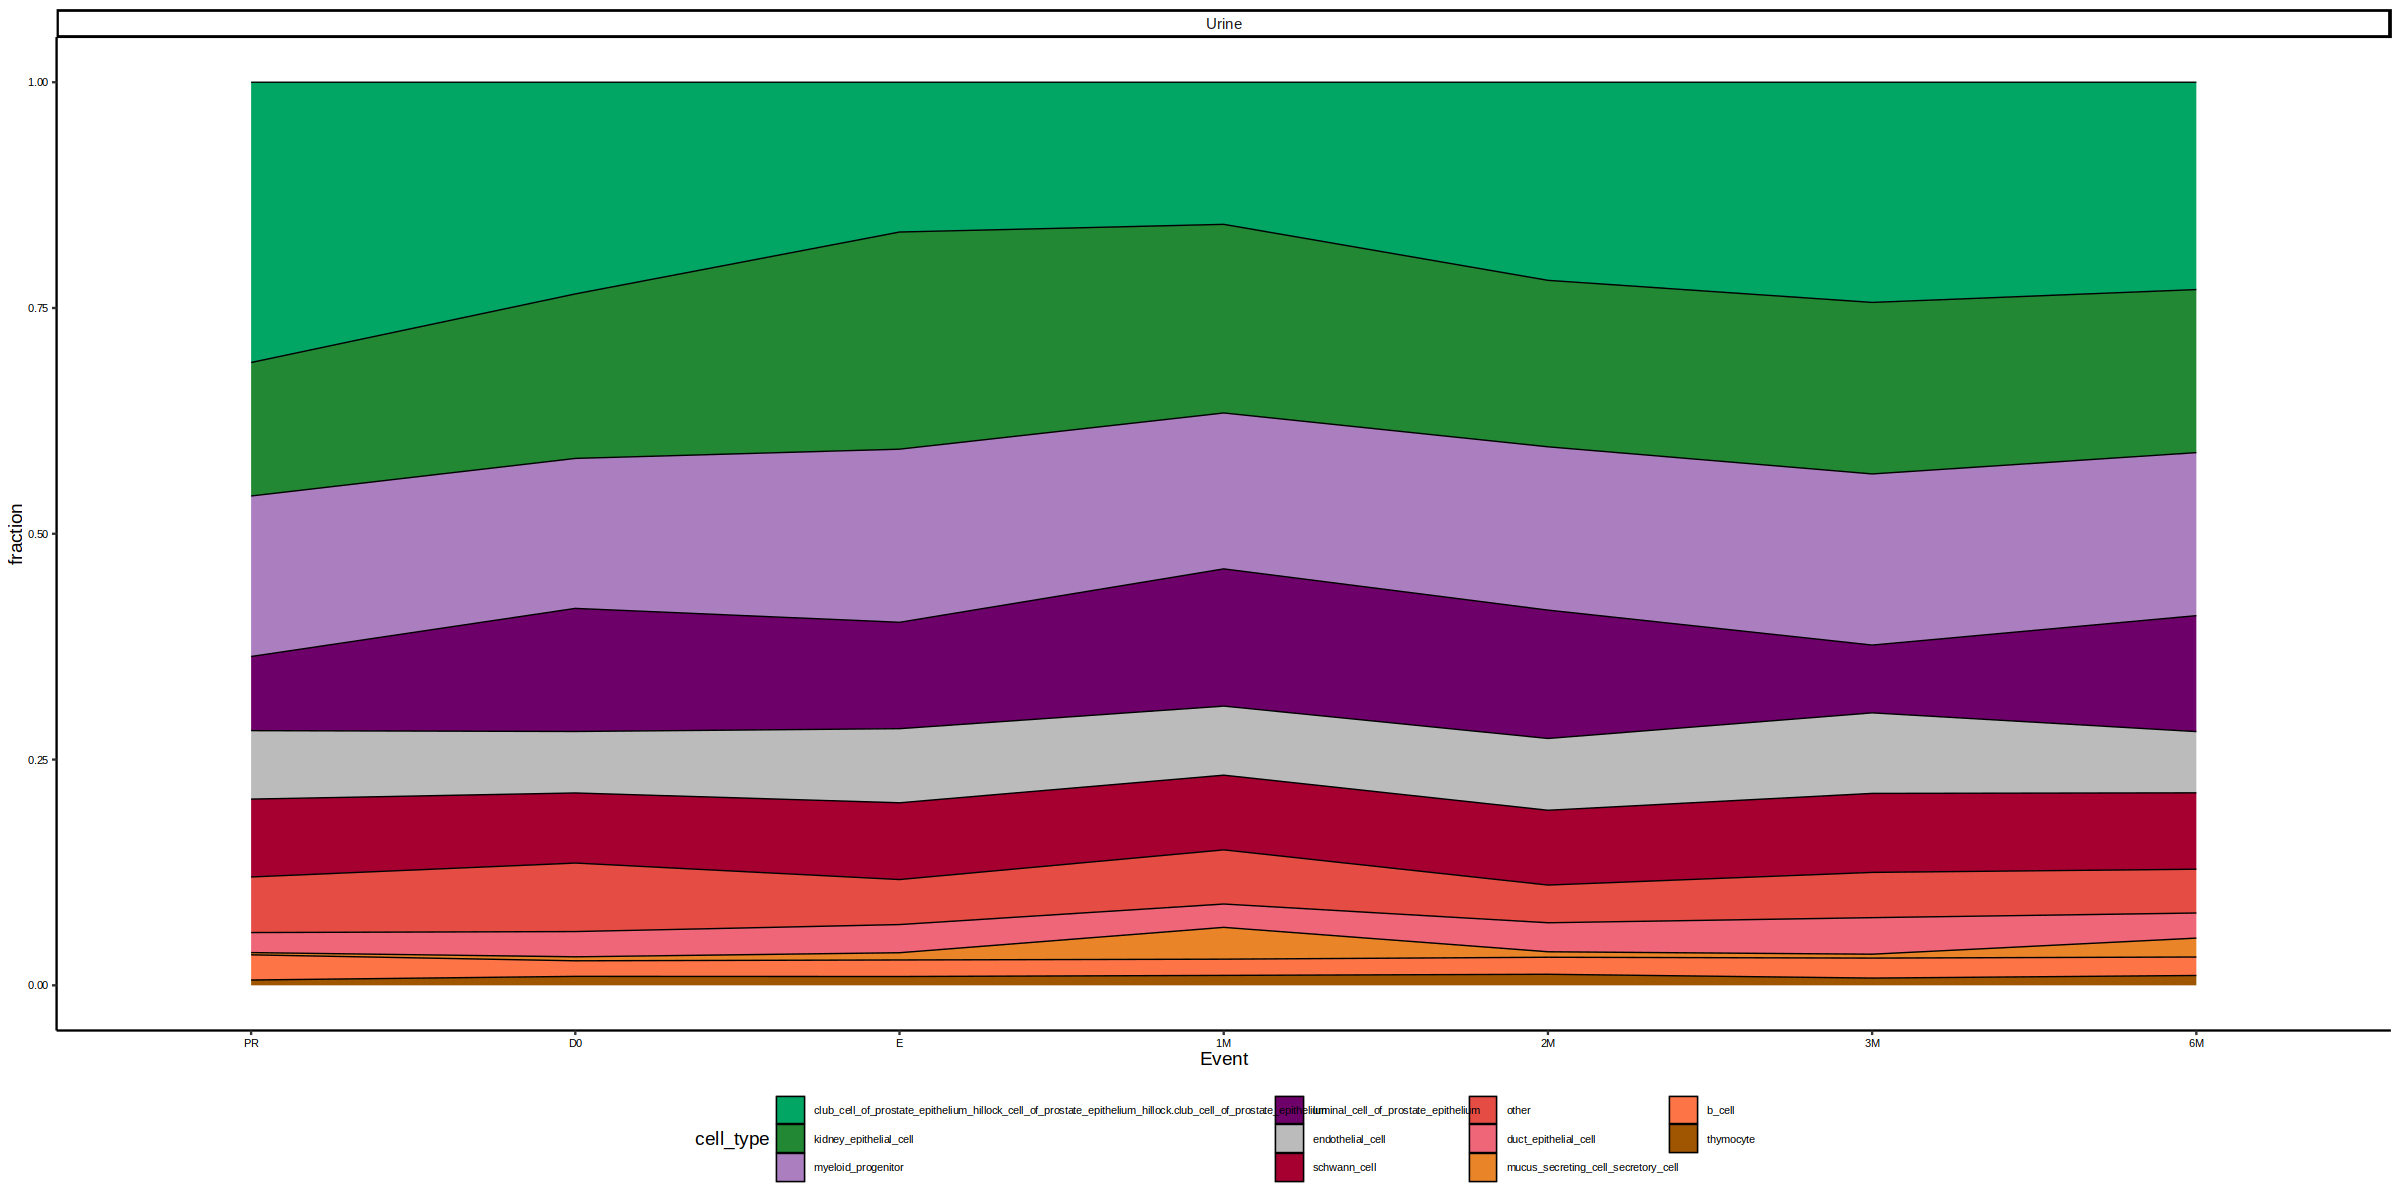

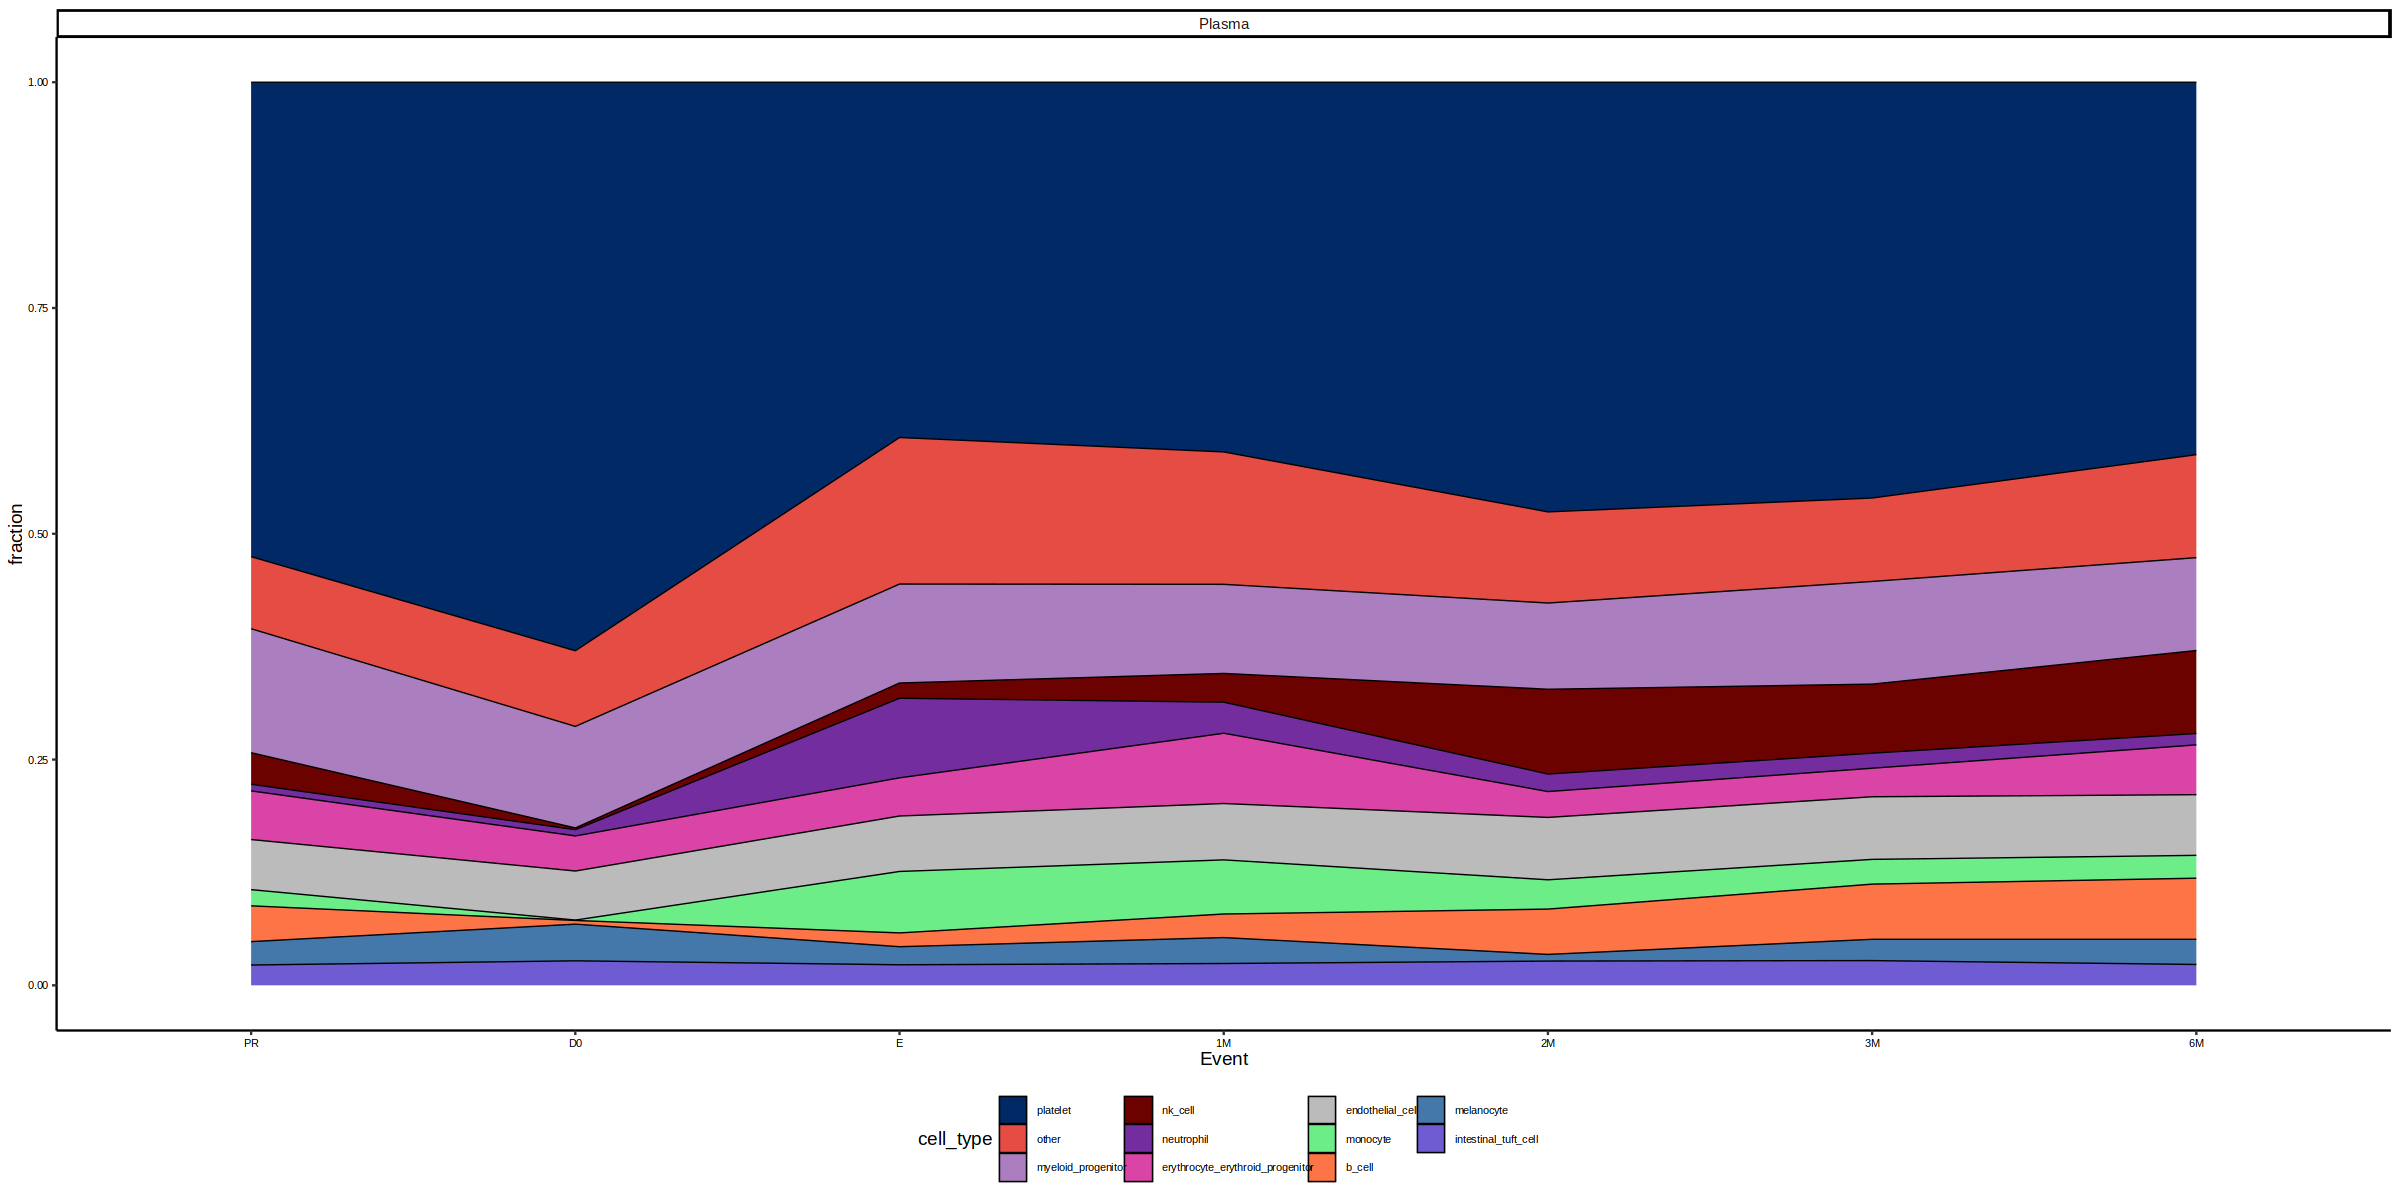

In [8]:
set.seed(seed)
# Assuming p2 and p3 are already created
my_palette<-sample(my_palette)
# Extract unique cell types from p2 and p3
common_cell_types <- intersect(levels(gvhd_tissuesUrine_means$cell_type), levels(gvhd_tissuesPlasma_means$cell_type))

# Create a color palette for common cell types
common_cell_colors <- setNames(my_palette[1:length(common_cell_types)], common_cell_types)

different_cell_types<-setdiff(union(levels(gvhd_tissuesUrine_means$cell_type), levels(gvhd_tissuesPlasma_means$cell_type)),common_cell_types)
different_cell_colors <- setNames(my_palette[length(common_cell_types)+1:length(my_palette)], different_cell_types)


all_colors=c(different_cell_colors,common_cell_colors)

# Update color mapping in p2
p5 <- p2 + scale_fill_manual(values = all_colors,na.value = NA)+theme(legend.position = "bottom")

# Update color mapping in p3
p6 <- p3 + scale_fill_manual(values = all_colors,na.value = NA)+theme(legend.position = "bottom")

# Plot p2 and p3
p5
ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_2/urine_cell_types.pdf", height=6.5 , width=7, units = "cm")
p6
ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_2/Plasma_cell_types.pdf", height=6.5 , width=7, units = "cm")